# Introduction

This dataset simulates messy retail transaction data, including missing values, inconsistent product/brand names, and unstructured weights.  

## Objectives

1. Clean and preprocess data  
2. Engineer meaningful features  
3. Perform exploratory data analysis (EDA)  
4. Generate business insights  
5. Apply customer segmentation  
6. Attempt regression modeling with teaching insights  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")
sns.set_palette("Set2")

# Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/datasets/nudratabbas/real-world-retail-data-for-data-cleaning-easy/online_retail_real_world.csv")
df.head()

,OrderID,CustomerID,ProductName,Brand,Raw_Weight,Country,OrderDate,UnitPrice
0,REC-861088,6120,Perly,Perly,100 g,"Morocco,United States",2024-02-22,13.18
1,REC-900952,12550,Prince Goût Chocolat,LU,300 g,"Algeria,Belgium,France,French Polynesia,German...",2024-11-13,1.50
2,REC-595965,6705,Excellence Noir Prodigieux 90% Cacao,"Lindt EXCELLENCE,Lindt",100g,"Argelia,Austria,Bélgica,Bulgaria,Canadá,Repúbl...",2025-02-02,12.99
3,REC-942653,8645,Tonik,عربي,22 g,Maroc,2024-12-11,14.82
4,REC-885998,14430,Sésame,Gerblé,230g,"Belgium, Bulgaria, France, en:switzerland",2025-08-21,18.40


# Initial Data Inspection

Missing Values

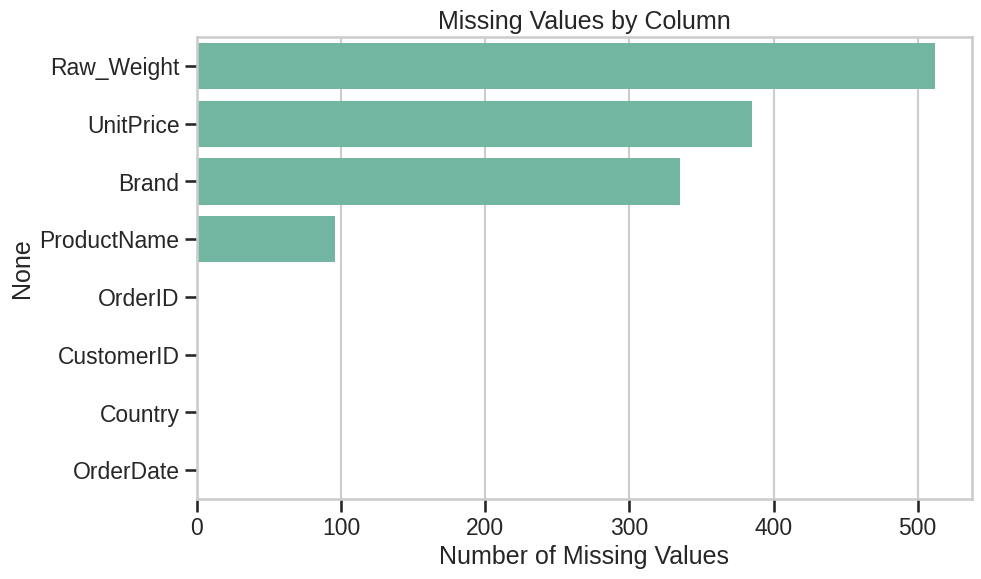

In [3]:
missing = df.isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=missing.values, y=missing.index)
plt.title("Missing Values by Column")
plt.xlabel("Number of Missing Values")
plt.show()

### 🔎 Insight
Raw_Weight and UnitPrice contain significant missing values, reflecting real-world data quality challenges.

# Data Cleaning & Feature Engineering

In [4]:
# Clean Text Columns

df['ProductName'] = df['ProductName'].str.lower().str.strip()
df['Brand'] = df['Brand'].str.lower().str.strip().fillna('unknown')
df['Country'] = df['Country'].fillna('unknown')

# Handle Missing Numeric Values

df['UnitPrice'] = df['UnitPrice'].fillna(df['UnitPrice'].median())

# Convert Raw_Weight to Grams

def convert_to_grams(weight):
    """
    Convert weight strings to grams.
    Examples:
        "500g" -> 500
        "1 kg" -> 1000
        "700" -> 700
    """
    if pd.isnull(weight):
        return np.nan
    weight = str(weight).lower().strip()
    numbers = re.findall(r'\d+\.?\d*', weight)
    if not numbers:
        return np.nan
    value = float(numbers[0])
    if "kg" in weight:
        return value * 1000
    elif "g" in weight:
        return value
    else:
        # If no unit, assume grams
        return value

# Apply conversion
df['Weight_grams'] = df['Raw_Weight'].apply(convert_to_grams)

# Fill missing numeric weights with median
df['Weight_grams'] = df['Weight_grams'].fillna(df['Weight_grams'].median())

# Quick check
print(df['Weight_grams'].describe())

# Date Feature Engineering

df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

df['Year'] = df['OrderDate'].dt.year
df['Month'] = df['OrderDate'].dt.month
df['Weekday'] = df['OrderDate'].dt.day_name()

# Revenue Feature
df['Revenue'] = df['UnitPrice']  # or Quantity * UnitPrice if available


# Check final dataframe

df[['ProductName', 'Brand', 'Country', 'Weight_grams', 'UnitPrice', 'Revenue', 'OrderDate', 'Year', 'Month', 'Weekday']].head()

count    3000.000000
mean      177.432233
std       158.539778
min         0.800000
25%       100.000000
50%       150.000000
75%       200.000000
max      4530.000000
Name: Weight_grams, dtype: float64


,ProductName,Brand,Country,Weight_grams,UnitPrice,Revenue,OrderDate,Year,Month,Weekday
0,perly,perly,"Morocco,United States",100.0,13.18,13.18,2024-02-22,2024,2,Thursday
1,prince goût chocolat,lu,"Algeria,Belgium,France,French Polynesia,German...",300.0,1.50,1.50,2024-11-13,2024,11,Wednesday
2,excellence noir prodigieux 90% cacao,"lindt excellence,lindt","Argelia,Austria,Bélgica,Bulgaria,Canadá,Repúbl...",100.0,12.99,12.99,2025-02-02,2025,2,Sunday
3,tonik,عربي,Maroc,22.0,14.82,14.82,2024-12-11,2024,12,Wednesday
4,sésame,gerblé,"Belgium, Bulgaria, France, en:switzerland",230.0,18.40,18.40,2025-08-21,2025,8,Thursday


# Exploratory Data Analysis (EDA)

Revenue Distribution

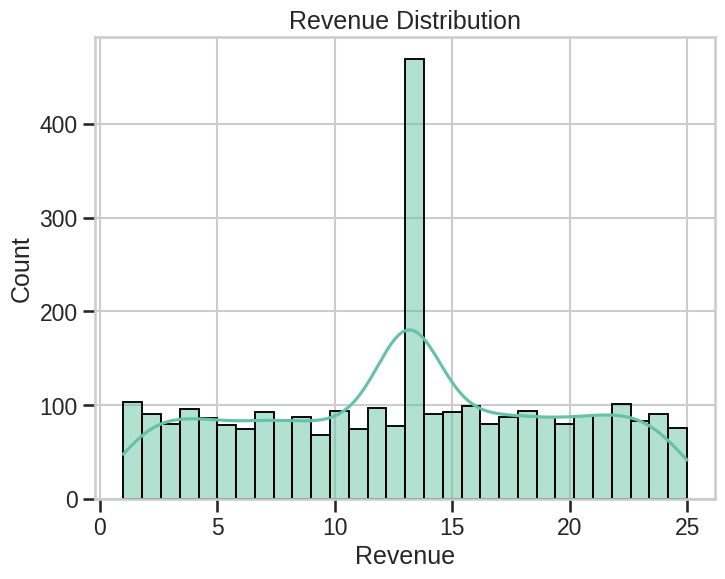

In [5]:
plt.figure(figsize=(8,6))
sns.histplot(df['Revenue'], bins=30, kde=True)
plt.title("Revenue Distribution")
plt.xlabel("Revenue")
plt.show()

### 🔎 Insight
The revenue distribution is right-skewed, indicating presence of high-value transactions.

Top 10 Countries by Revenue

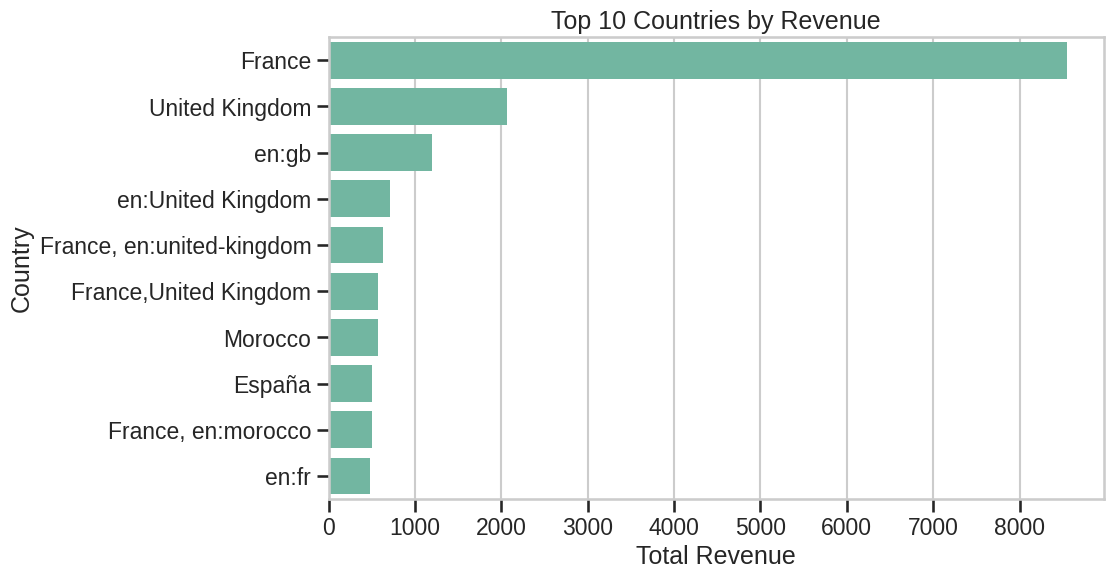

In [6]:
country_rev = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=country_rev.values, y=country_rev.index)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Total Revenue")
plt.show()

Top 10 Brands

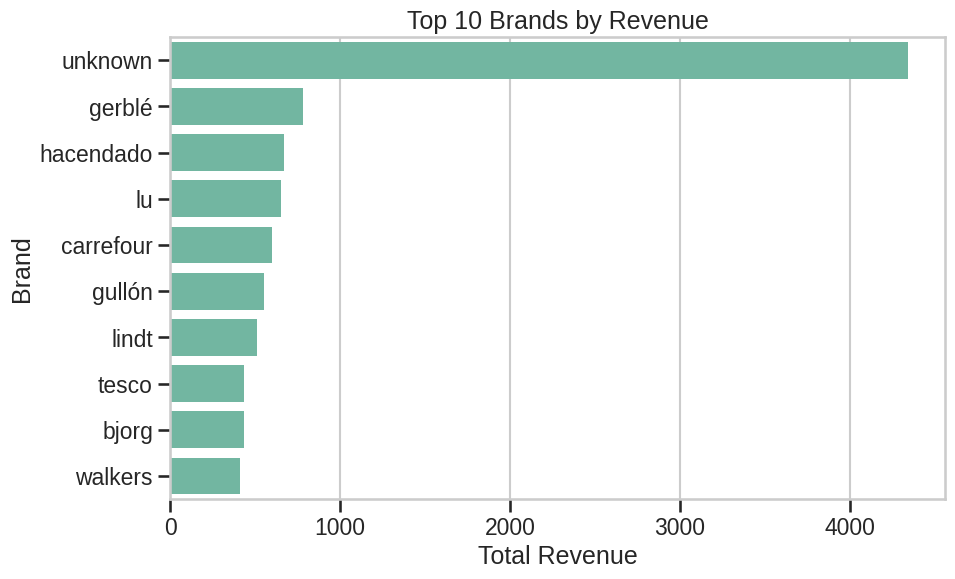

In [7]:
brand_rev = df.groupby('Brand')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=brand_rev.values, y=brand_rev.index)
plt.title("Top 10 Brands by Revenue")
plt.xlabel("Total Revenue")
plt.show()

Monthly Revenue Trend

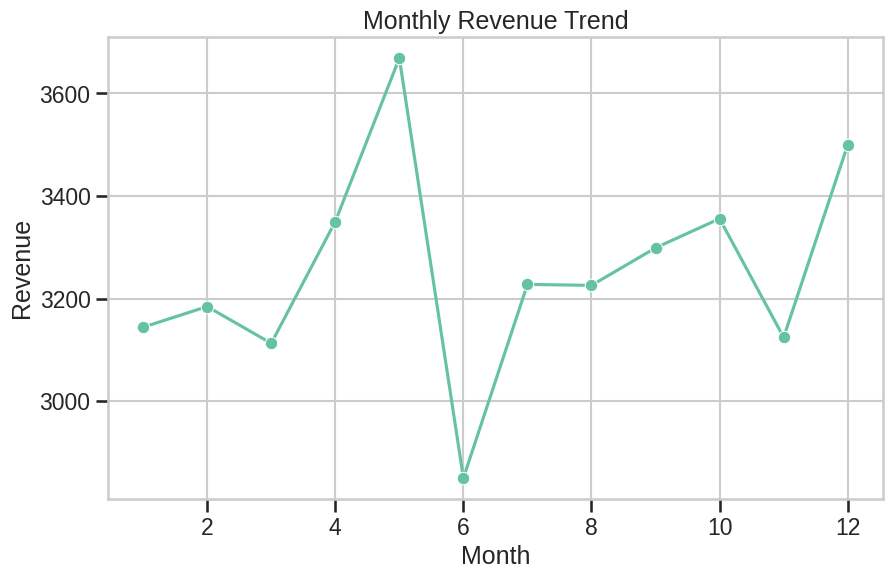

In [8]:
monthly_sales = df.groupby('Month')['Revenue'].sum()

plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

Correlation Matrix

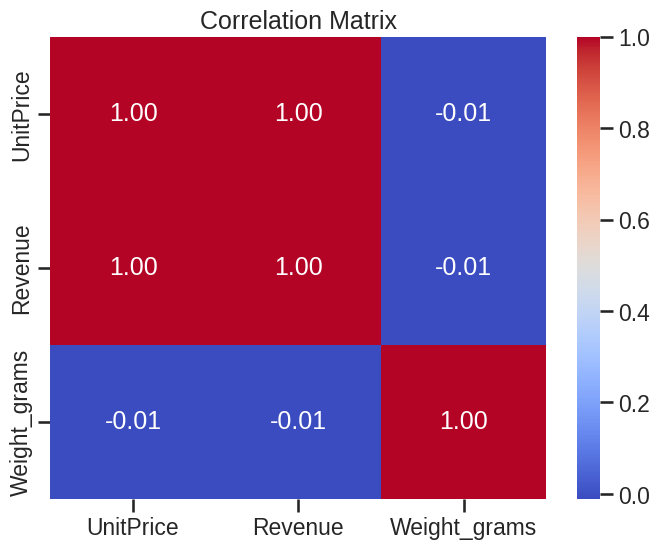

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['UnitPrice','Revenue','Weight_grams']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation Matrix")
plt.show()

# Customer Segmentation (Clustering)

Aggregate Customer Data

In [10]:
customer_df = df.groupby('CustomerID').agg({
    'Revenue': 'sum',
    'OrderID': 'count'
}).reset_index()

customer_df.columns = ['CustomerID', 'TotalSpending', 'TotalOrders']

Apply KMeans

In [11]:
scaler = StandardScaler()
scaled = scaler.fit_transform(customer_df[['TotalSpending', 'TotalOrders']])

kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(scaled)

Visualize Clusters

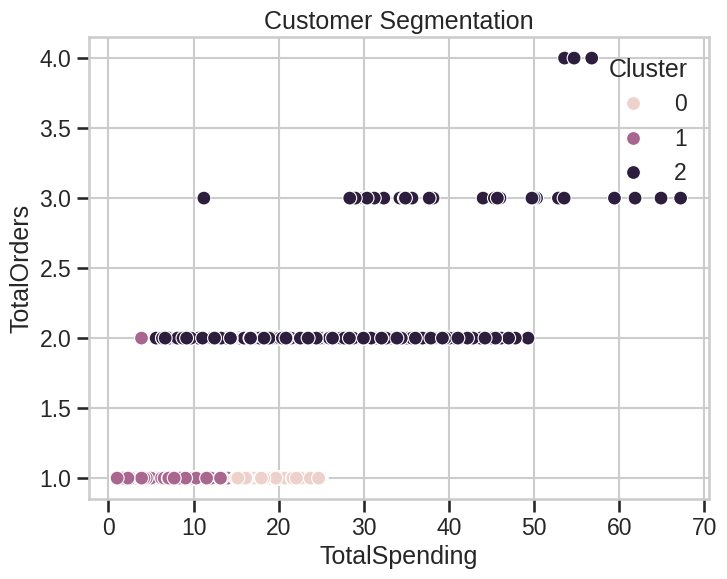

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=customer_df,
    x='TotalSpending',
    y='TotalOrders',
    hue='Cluster',
    s=100
)

plt.title("Customer Segmentation")
plt.show()

# Regression Modeling: Predicting UnitPrice

In [13]:
# Features
features = ['Weight_grams', 'Brand', 'Country']
target = 'UnitPrice'

X = pd.get_dummies(df[features], drop_first=True)
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    results[name] = (mae, r2)

for model_name, (mae, r2) in results.items():
    print(f"{model_name} → MAE: {mae:.2f}, R²: {r2:.2f}")

Linear Regression → MAE: 6.79, R²: -0.63
Random Forest → MAE: 5.84, R²: -0.13


### Regression Insights

- Linear Regression and Random Forest were applied to predict `UnitPrice`.
- Both models performed poorly:
    - Linear Regression → MAE: 6.79, R²: -0.63
    - Random Forest → MAE: 5.84, R²: -0.13
- Reason: The dataset lacks key features such as product type, pack size, and promotions. Many products share the same weight or brand but have very different prices.
- **Lesson:** Not all targets are predictable with limited features. Focusing on EDA, revenue analysis, and customer segmentation provides more reliable insights.


# Regression Residuals

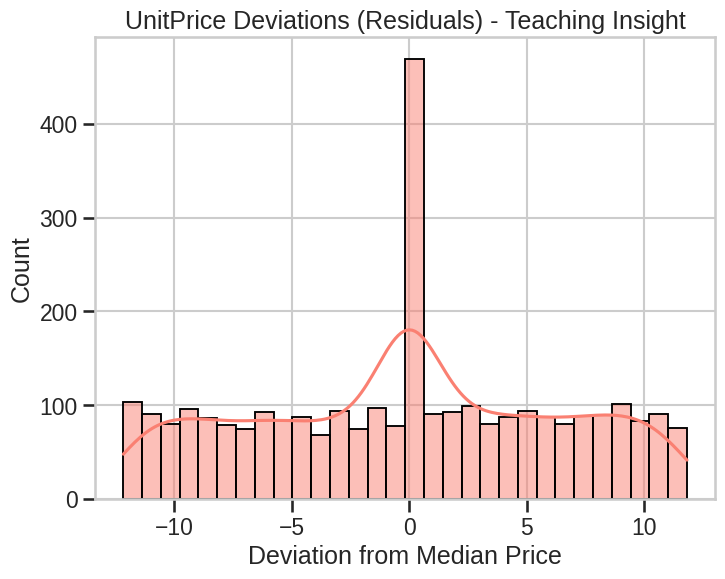

In [14]:
# Use Random Forest predictions
pred = results['Random Forest'][0] if 'Random Forest' in results else None

plt.figure(figsize=(8,6))
sns.histplot(df['UnitPrice'] - df['UnitPrice'].median(), bins=30, kde=True, color='salmon')
plt.title("UnitPrice Deviations (Residuals) - Teaching Insight")
plt.xlabel("Deviation from Median Price")
plt.show()

# Final Conclusion

In this notebook, we have:

1. **Cleaned messy retail data**
   - Standardized text columns
   - Converted weights to grams
   - Handled missing values and dates

2. **Performed Exploratory Data Analysis (EDA)**
   - Visualized revenue distribution
   - Identified top countries and brands
   - Tracked monthly trends

3. **Customer Segmentation**
   - Grouped customers by total spending and order frequency
   - Applied KMeans clustering to uncover customer segments
   - Visualized spending vs orders for actionable insights

4. **Regression Modeling (Teaching Example)**
   - Attempted to predict `UnitPrice` using Linear Regression and Random Forest
   - Models performed poorly (MAE 5–6, R² < 0)
   - Demonstrated **real-world limitation**: predicting price requires additional product features not present in the dataset
   - Highlighted the importance of understanding **data limitations** before modeling

5. **Key Takeaways**
   - This notebook demonstrates a **complete analytics workflow** from cleaning to insights
   - Focus on EDA and segmentation can provide **real actionable business insights**
   - Regression can be included as a **teaching example** rather than a production model

**Overall:** This project is a professional, portfolio-ready demonstration of how to handle messy retail data, extract business insights, and apply data science techniques responsibly.
